# Julia 6: Introduction to ModelingToolkit
### Bernt Lie
#### University of South-Eastern Norway
#### September 2023
## 0. Preamble
### 0.1. Content
This notebook gives an introduction to the modeling language ModelingToolkit for Julia. ModelingToolkit is a language within Julia for describing mathematical models, consisting of differential equations, algebraic equations, optimization problems, etc. ModelingToolkit uses package `Symbolics` for symbolic manipulation of models -- package `ModelingToolkit` handles import of needed `Symbolics` code, so there is no need to separately import `Symbolics`. In the final stage, `ModelingToolkit` converts the symbolic form to a numeric form. In order to solve the numeric form, solvers from the `DifferentialEquations` (and other packages in the case of optimization) are needed.

This document is organized as follows:

0. This preamble continues with information about how to install packages on your computer, how to import them in this computational session, and adds some "constants" that are used to give uniform plot results that can easily be changed in one central location (= Section 0.3).

1. Discusses basic use of Modeling Toolkit for a simple DAE model of a water tank. Emphasis is on various ways of declaring variables and parameters, and equations leading to a symbolic model. Then how the symbolic model can be reduced to an ODE or a DAE of index 1, and next how to convert the symbolic model to numeric problem which finally is solved, and plotted. 

2. Extends the water tank model with an input, and repeats ideas from Section 1. Of importance is how to specify input/driving functions, and how to make them available symbolically to ModelingToolkit (`register_symbolical`). It is illlustrated how to find steady state so that the model simulation can start from steady state.

3. Discusses ways to fine-tune the model implementation.

4. Here, a "Best practice" for specifying the model is summarized, based on what is learnt from Sections 1-3. The proposed strategy prepars the model for later use for symbolic linearization.

5. For more efficient modeling of complex systems, the possibility to re-use code is important. This section give an initial glimpse into how to describe a model "class" with a model constructor which can then be used to instantiate copies of the model "class". It is also illustrated how to define connections between the instantiated models. This is done by putting two water tank models in series, where water flows out of one of them, and into the second.

6. Finally, a DAE model is introduced to illustrate the case when function `structural_simplify` does *not* reduce the model to an ODE, but instead results in a DAE. This has implications wrt. choice of solver. 

### 0.2. Installing packages

In [1]:
#= ... in case this has not been done already
using Pkg
Pkg.add(["ModelingToolkit", "DifferentialEquations",...])
=#

### 0.3. Importing packages

In [2]:
using ModelingToolkit
using DifferentialEquations
using Plots, LaTeXStrings
using BenchmarkTools
using Latexify

### 0.4. Constants

In [3]:
# Specifying line properties as constants makes it possible to globally 
# change these values and keep consistency
LW1 = 2.5
LC1 = :red
LC2 = :blue
LC3 = :green
LC4 = :orange

LS1 = :solid 
LS2 = :dash

figpath = "C:/Users/Bernt_Lie/OneDrive/Documents/booksBLSOL/ModDynSyst/figs/"
figtype = ".svg"
SAVEFIG = true
;

## 1. Constant area tank without influent
### 1.1. Model of tank
We consider the following model of a simple water tank with mass $m$, influent mass rate  $\dot{m}_\mathrm{e}$, effluent mass rate $\dot{m}_\mathrm{e}$,
$$
\frac{\mathrm{d}m}{\mathrm{d}t} = \dot{m}_\mathrm{i} - \dot{m}_\mathrm{e}
$$
Water has density $\rho$, leading to a water volume $V$ contained in the tank which has constant cross sectional area $A$. The resulting water level is $h$, 
$$
m = \rho\cdot V \\
V = A\cdot h
$$
We will assume that the effluent is driven by gravity, and can be related to water level via a Bernoulli type rate
$$
\dot{m}_\mathrm{e} = K\cdot \sqrt{\frac{h}{h^\varsigma}}
$$
In summary: we have
* 4 parameters:  $\rho$, $A$, $K$, $h^\varsigma$
* 5 unknowns $m$, $\dot{m}_\mathrm{i}$, $\dot{m}_\mathrm{e}$, $V$, $h$. 
* 4 equations

To complete the model, we need to specify the influent flow rate $\dot{m}_\mathrm{i}$ as a known function.

Initially, we will assume that there is no influent, i.e., that $\dot{m}_\mathrm{i} \equiv 0$. Later we will relax on this.

### 1.2. Variables, parameters, and differentiaton operator

In [4]:
@variables t m(t) ṁ_e(t) V(t) h(t)      # ṁ is created by typing m + \dot + TAB
@parameters ρ A K h_ς                   # ρ and ς are created by using LaTeX syntax + TAB
Dt = Differential(t)
;

Here, variables and parameters can either be separated by space, or by comma, i.e., `@variables a b c` and `@variables a,b,c` give the same result.

In [5]:
@variables t, m(t), ṁ_e(t), V(t), h(t)
@parameters ρ, A, K, h_ς
Dt = Differential(t)
;

### 1.3. Naive implementation
In Julia, symbol `=` implies *assignment*. Because this symbol thus already is taken, language ModelingToolkit instead uses symbol `~` to signify mathematical equality. [NOTE: `~` is the symbol found on the computer keyboard. Do not use the $\LaTeX$ symbol `\sim`.]

In [6]:
eqs_1 = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank = ODESystem(eqs_1)

Model tank with 4 equations
States (4):
  m(t)
  ṁ_e(t)
  V(t)
  h(t)
Parameters (4):
  ρ
  A
  h_ς
  K

Observe that this is a *symbolic* description of the model. So far, there is no requirement that the model is balanced, i.e., it is possible to specify a system with different number of equations and unknowns.

Sometimes, it may be necessary to specify the independent variable. To do so, use the following syntax - if the independent variable is `t`:
```julia
@named tank = ODESystem(eqs_1,t)
```

### 1.4. Simplification and index reduction
Before we procede, it is useful to have an understanding of Differential Algebraic Equations [DAE:s], and specifically DAE:s of so-called *index 1*. DAE:s that we will meet can often be described in the following form:
$$
M\frac{\mathrm{d}x}{\mathrm{d}t} = f(x,u;t)
$$
where $M$ is a possibly singular matrix and there are some requirements on $f(\cdot)$.

If matrix $M$ is non-singular = has full rank = can be inverted, we can always convert the model to an Ordinary Differential Equation [ODE] as 
$$
\frac{\mathrm{d}x}{\mathrm{d}t} = M^{-1}\cdot f(x,u;t)
$$

An ODE is a DAE of index 0, and can be solved by ODE solvers. 

If $M$ is singular, we can *not* use a standard ODE solver. Suppose the structure of $M$ is block diagonal with non-singular $M_1$ in the first diagonal block and $M_2 = 0$ in the second, and we partition $x$ into $x_1, x_2$, we can write the equation as
$$
M_1 \frac{\mathrm{d}x_1}{\mathrm{d}t} = f_1(x_1,x_2,u;t) \\
0 = f_2(x_1,x_2,u;t).
$$
The system is then a DAE of index 1 if the Jacobian $\partial f_2(x_1,x_2,u;t)/\partial x_2$ is non-singular for all values of $(x_1,x_2,u;t)$, in other words, we can solve the second equation wrt. $x_2$ and insert the resulting expression into the first equation.

If the system is a DAE of index 1, we can solve the model using mass matrix DAE solvers where we specify $M$.

If the system is a DAE of *index higher than 1*, it is possible to algorithmically reduce it to an index 1 DAE by eliminating variables and/or adding new variables.

ModelingToolkit command `structural_simplify` performs reduction of the original model to a DAE of index 1, and more: `structural_simplify` removes redundant equations, removes redundant variables and puts them into a class `observed`, and reduces the equations to a DAE of index 1. Furthermore, ModelingToolkit automatically handles the set-up of the $M$ matrix -- we don't have to think about it. We only need to know that we must use a solver with support for mass matrix.

**NOTE**: In order for `structural_simplify` to work, it must be possible to reduce the model to a system where the number of equations and the number of remaining unknowns are equal, i.e., we must provide a balanced system with the same number of equations and unknowns.

In [7]:
tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t)
Parameters (4):
  ρ
  A
  h_ς
  K
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

Note that this simplified model apparently has $m$ as state and $\dot{m}_\mathrm{e}$ on the right hand side (here, *matrix* $M=1$). Clearly, this is not a complete model - the equation does not show the relationship between $m$ and $\dot{m}_\mathrm{e}(h)$!
However, the key thing to understand from the above equation is that we (i) need to provide initial value for $m$ (since the equation shows the time derivative of $m$), and (ii) the relationship between $m$ and $h$ is still there, but it is hidden. Requesting the `equations` for the model gives:

In [8]:
equations(tank_simp)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ -ṁ_e(t)

which is the same as above and does not provide more information. However, command `full_equations` writes the model in state-space form (but still hides some algebraic equations needed to compute the remaining variables):

In [9]:
full_equations(tank_simp)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ -K*sqrt(m(t) / (A*h_ς*ρ))

### 1.5. States, Observed, and Parameters

We can also inspect *states*, *observed*, and *parameters*.

*States*

**NOTE**: in the ModelingToolkit *lingo*, "state" means *unknown* in the *structurally simplified model*, i.e., it equals $x$ in the simplified index 1 DAE model $M\frac{\mathrm{d}x}{\mathrm{d}t} = f(x,u;t)$.

In [10]:
states(tank_simp)

1-element Vector{Any}:
 m(t)

In fact, it is the variables shown by command `states(tank_simp)` that we need to provide initial values for.

*Observed*

When going from the original model formulation with its defined *variables*, doing `structural_simplify` removes some of these variables because they are not needed in the reduced index 1 DAE. These *removed* variables are denoted **observed**. The *observed* variables are not involved when finally solving the model numerically, but ModelingToolkit still needs to keep track of them so that they can be plotted, etc. 

To this end, let $x$ be the "states" in the index 1 DAE simplified model, and let $\omega$ be the *observed* variables. `structural_simplify` then removes $\omega$ from the model, but will still keep track of how $\omega$ can be computed as $\omega = g(\omega,x,u)$ (where the $\omega$ dependence in $g(\cdot)$ is such that $\omega$ can be easily computed, e.g., $\omega_1 = g_1(x,u)$, $\omega_2 = g_2(\omega_1,x,u)$, etc.). The unknowns in the union of $x$ and $\omega$ will provide the solution to all variables in the *original* model, i.e., before structural simplification.

In [11]:
observed(tank_simp)

3-element Vector{Equation}:
 V(t) ~ m(t) / ρ
 h(t) ~ V(t) / A
 ṁ_e(t) ~ K*sqrt(h(t) / h_ς)

In [12]:
parameters(tank_simp)

4-element Vector{SymbolicUtils.BasicSymbolic{Real}}:
 ρ
 A
 h_ς
 K

Note that the concept of "state" in ModelingToolkit may be different from the way "state" is defined in traditional dynamic systems literature, but here the interpretations coincide.

In summary, ModelingToolkit refers to the unknowns (after structural simplification?) as states. The remaining unknowns are computed by some hidden algebraic relations, and are referred to as *observables* or *observed variables*.

### 1.6. Converting symbolic model to numeric model

So far, we have operated with a symbolic model (instantiated by function `ODESystem`). We now are ready to create a *numeric implementation* of the model using function `ODEProblem`, where we also need to specify:

* initial "state" -- this means that we need to specify initial values for all variables given by command `states(tank_simp)`,
* time span for the simulation -- in the form of a tuple consisting of the start time and end time, and 
* numeric values for all parameters.

In [13]:
x0 = [m => 1.5*ρ*A] # Specifying initial state(s)
tspan = (0.0,3.8)   # Specifying tuple of initial and final time
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)
;

**NOTE**: It is possible to specify initial states via parameter values. It is, in fact, also possible to express parameter values via other parameter values. We will get back to this.

### 1.7. Providing *default* values in model
Above, we have provided values for initial state `x0` and parameters `par` as arguments in the constructor `ODEProblem` for the numeric implementation.

We could *alternatively* have given the parameters and variables *default* values in the original symbolic model. There are two ways to do this:

**Alternative 1**:

In [14]:
@variables t m(t)=1.5*ρ*A ṁ_e(t) V(t) h(t)      # ṁ is created by typing 
                                                # m + \dot + TAB
@parameters ρ=1 A=5 K=5 h_ς=3
Dt = Differential(t)

eqs_1 = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank = ODESystem(eqs_1)
tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

**NOTE**: We can now use the constructor `ODEProblem` without providing initial values for the "states" (because it is a positional argument, we need to set an empty bracket `[]`) and without providing values for the parameters (parameters are also positional arguments, but we don't need to provide an empty bracket `[]` because it is the last of the positional arguments...)

In [15]:
prob = ODEProblem(tank_simp, [], tspan)
;

If we decide that we don't *like* the default values, we can still override them in constructing the numeric model:

In [16]:
prob = ODEProblem(tank_simp, [m => 1.7*ρ*A], tspan, [A=>7])
;

**Finally**: observe that when giving default values for parameters and "states", we do not have to provide default values for all parameters and (initial values for all) states. But the combination of specified default values and the actual values provided in the constructor `ODEProblem` must specify all parameters and initial values for all "states".

**Alternative 2**:
We can alternatively provide defaults by assigning a *dictionary* to keyword argument `defaults` of the symbolic constructor `ODESystem`. 

In [17]:
@variables t m(t) ṁ_e(t) V(t) h(t)
@parameters ρ A K h_ς
Dt = Differential(t)

eqs_1 = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank = ODESystem(eqs_1; defaults = Dict(ρ=>1, A=>5, K=>5, 
                h_ς=>3, m=>1.5*ρ*A))
tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

Obviously, default values can be overridden for Alternative 2 just as for Alternative 1.

### 1.8. Numerical *solution* of the model
To solve the numeric implementation of the model (instantiated by `ODEProblem`), we use method `solve`, with the name of the problem as argument. Here, we could also specify which numeric solver to use, accuracy, etc., but we will use default values initially.

If the resulting model from `structural_simplify` (either directly, or via `equations(tank_simp)` or `full_equations(tank_simp)`) consists of only differential equations, then the resulting model is a system of Ordinary Differential Equations, and an ODE solver can be used. In principle, all solvers for `DifferentialEquations.jl` under **ODE Solvers** can be used.

However, if the result from `structural_simplify` consists of both differential equations and algebraic equations, then a solver that supports *mass matrix* is required. Solvers with support for mass matrix are listed in the documentation for `DifferentialEquations.jl`, under **DAE Solvers** [more precisely, `OrdinaryDiffEq.jl (Mass Matrix)` heading].

Solving the numeric *problem* formulation `prob` is done via function `solve`, which comes from the `DifferentialEquations.jl` package. In other words, to execute the `solve` function, we must have imported the `DifferentialEquations` package.

In [18]:
sol = solve(prob);

Function `solve` allows one to specify the numeric solver as the *second* positional argument of the `solve` function. If you want to specify solver, `Tsit5()` is one possibility. If the simplified model has a mass matrix $M$, it is required to use DAE solver which supports mass matrices, e.g., `QBDF()`.

The call would then be, e.g.,
```julia
sol = solve(prob, Tsit5())
```
It is also possible to add a number of keyword assignments to the `solve` function. Some relevant keyword assignments are `reltol` (relative tolerance), `abstol` (absolute tolerance), `saveat` (the time interval between when solutions should be saved), etc.

Example:
```julia
sol = solve(prob; reltol=1e-3)
```

### 1.9. Numerical quality of model
If the simulation time is too long, the level of our tank example may become negative due to numeric error. Then the solver takes the square root of a negative number, and crashes due to the resulting complex value. This happens with end time between 3.8 and 3.9 seconds.

In [19]:
x0 = [m => 1.5*ρ*A] # Specifying initial state(s)
tspan = (0.0,3.8)   # Specifying tuple of initial and final time.
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)

sol = solve(prob);

### 1.10. Crude plotting of solution
The solution `sol` is a data structure of the solution in the time points given by `sol.t` or `sol[t]`, i.e., it contains vectors of solutions. However, soluiton data structure `sol` also contains interpolation function for the solution.

In [20]:
sol.t |> permutedims    # "transpose"/permute dimension to save vertical space

1×8 Matrix{Float64}:
 0.0  0.116234  0.686968  1.54617  2.39379  3.25075  3.70489  3.8

In [21]:
sol[t] |> permutedims

1×8 Matrix{Float64}:
 0.0  0.116234  0.686968  1.54617  2.39379  3.25075  3.70489  3.8

In [22]:
sol[m] |> permutedims

1×8 Matrix{Float64}:
 7.5  7.09468  5.26784  3.02957  1.42429  0.410362  0.12082  0.081911

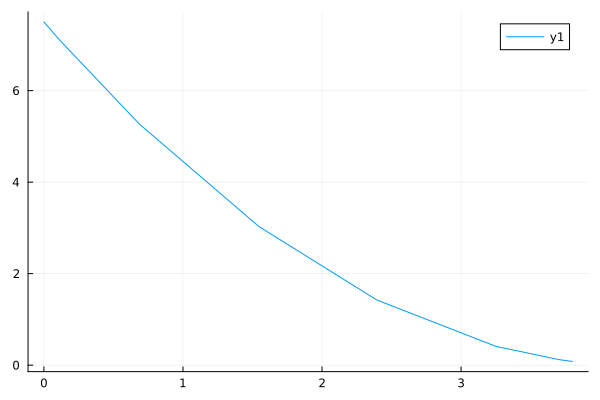

In [23]:
plot(sol[t],sol[m])

Note the jagged quality of the plot. The reason is that `plot` draws straight lines between the points given by `sol[t]` and `sol[m]`; we have only a few values of each pair `sol[t]` and `sol[m]`:

In [24]:
length(sol[t])

8

### 1.11. Smooth plotting of solution
Instead of plotting the *data points* of the solution by specifying `sol[t], sol[m]`, we can plot the *interpolation function* embedded in the `sol` data structure, which is smooth -- the `plots` command chooses a number points to compute the solution in, in order to give a nice plot.

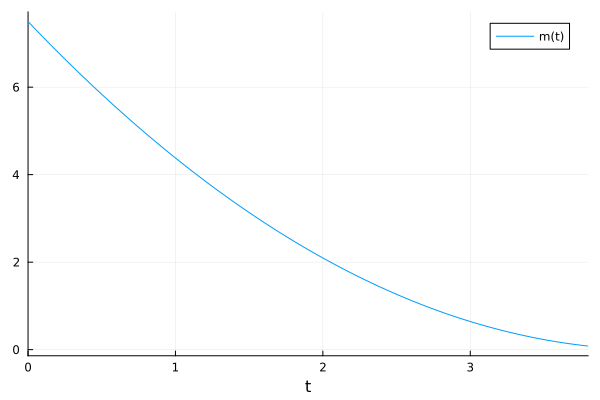

In [25]:
plot(sol)

Note the smooth quality of the plot. The reason is that `plot` here uses the *interpolation* function embedded in the solution object `sol`, and can therefore compute values for $m$ for many more time instances $t$ than the few values in $sol.t$. [Also note that `plot` adds an xlabel (`t`) and a label for the plot `m(t)`].

Let us refine the plot slightly, and plot level `h` instead of mass `m`.

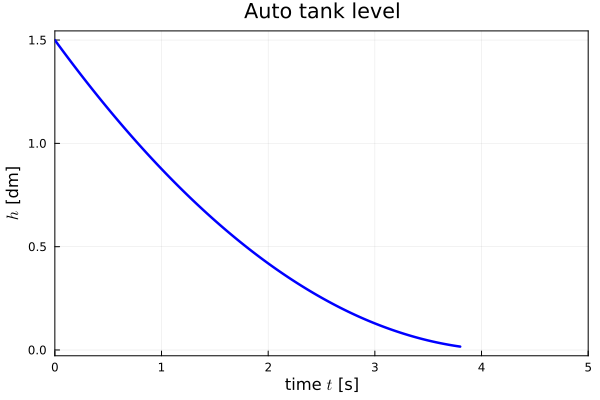

In [26]:
plot(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label="")
plot!(title="Auto tank level", xlabel=L"time $t$ [s]",ylabel=L"$h$ [dm]",
        xlims=(0,5))
plot!(framestyle =:box, grid=true)

In [27]:
if SAVEFIG
    figname = "autoTankSim-1"
    savefig(figpath*figname*figtype)
end
;

We could also manually use the interpolation function as follows (to illustrate that we can interpolate in many more points than the `length(sol.t)` = 19 points when plotting the vectors of the solution).

Let us first check the result of interpolating over a sequence of numbers:

In [28]:
sol.(0:0.5:3)

7-element Vector{Vector{Float64}}:
 [7.5]
 [5.836399378505207]
 [4.3811215918217465]
 [3.1342013737081835]
 [2.0955551406376474]
 [1.2652130233314103]
 [0.6432173337131979]

The result is a *vector of vectors*, but we need a simple vector of scalars. To convert the above result to the needed form, a relatively simple and efficient method is the following:

In [29]:
reduce(vcat, sol.(0:0.5:3))

7-element Vector{Float64}:
 7.5
 5.836399378505207
 4.3811215918217465
 3.1342013737081835
 2.0955551406376474
 1.2652130233314103
 0.6432173337131979

Now we can do the plotting, this time with some refinements:

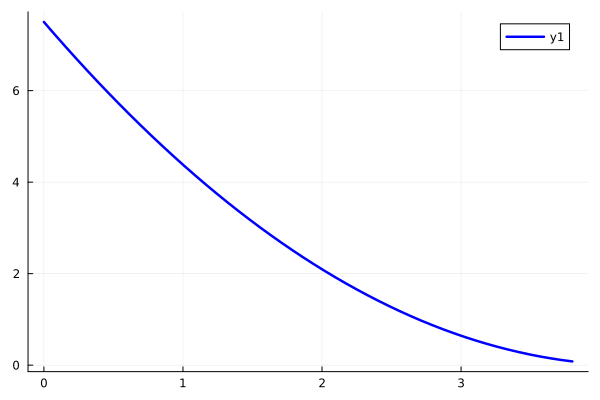

In [30]:
tm = range(0,3.8,length=50)
plot(tm,reduce(vcat,sol.(tm)),lw=LW1,lc=LC2)

Again, note the smooth quality of the plot. Also, since we selected the data points manually by manual interpolation, `plot`has not added labels.

### 1.12. Robustified model implementation
The absolute value of the level is taken inside of the square root, to avoid generation of a complex number. We also include the sign function of level + the max value to make sure that the effluent flow rate is not allowed to *enter* the tank.

In [31]:
eqs_2 = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ max(K*sign(h)*sqrt(abs(h/h_ς)),0)]

@named tank = ODESystem(eqs_2)

Model tank with 4 equations
States (4):
  m(t)
  ṁ_e(t)
  V(t)
  h(t)
Parameters (4):
  ρ
  A
  h_ς
  K

In [32]:
tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t)
Parameters (4):
  ρ
  A
  h_ς
  K
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [33]:
x0 = [m => 1.5*ρ*A] # Initial state
tspan = (0,5)   # Time span
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)

sol = solve(prob);

### 1.13. Understanding the solution `sol`
The solution object `sol` is dual-faced: It is a vector of solutions of the state at given time points, just like in other computing tools:

In [34]:
sol.t'   # Transpose to save vertical space; alternative to using `permutedims` function

1×19 adjoint(::Vector{Float64}) with eltype Float64:
 0.0  0.116234  0.686968  1.54617  2.39379  …  4.24579  4.25608  4.35897  5.0

In [35]:
sol[m]'

1×19 adjoint(::Vector{Float64}) with eltype Float64:
 7.5  7.09468  5.26784  3.02957  1.42429  …  -5.55509e-7  -5.55509e-7

NOTE: if we want to find the time point of the *other* variables, i.e., those which are not states, we simply do as follows:

In [36]:
sol[ṁ_e]'

1×19 adjoint(::Vector{Float64}) with eltype Float64:
 3.53553  3.43867  2.96306  2.24706  …  0.00640682  0.0  0.0  0.0  0.0

The way this works is that ModelingToolkit keeps track of equations for how these non-state variables = *observed* variables relate to the states, which have actually be computed. Then the solution of these observed variables are computed from these equations.

One more example:

In [37]:
sol[h]'

1×19 adjoint(::Vector{Float64}) with eltype Float64:
 1.5  1.41894  1.05357  0.605914  0.284859  …  -1.11102e-7  -1.11102e-7

**NOTE THAT** `sol` in *addition* contains interpolations of the solution, which serves two purposes: (i) plotting the solution as an interpolation gives considerably smoother plots, and (ii) we can interpolate and compute the solution at other time instances than those provide by `sol.t`:

In [38]:
sol(0.5)

1-element Vector{Float64}:
 5.836399378505207

Observe that `sol(0.5)` provides the *state* (here: $m$) at time $t=0.5$.

Suppose that we instead want an interpolated value of *observed* variables? This can be done as follows:

In [39]:
sol(0.5; idxs = ṁ_e)

3.1188671497049496

In [40]:
sol(0.5; idxs = [ṁ_e, h])

2-element Vector{Float64}:
 3.1188671497049496
 1.1672798757010414

### 1.14. Simulation results
First, we plot the level:

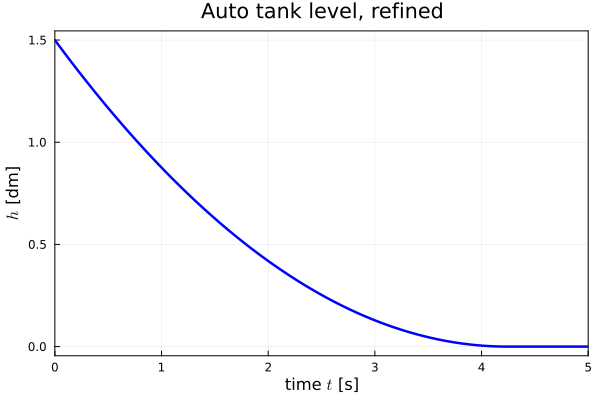

In [41]:
plot(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label="")
plot!(title="Auto tank level, refined", xlabel=L"time $t$ [s]",ylabel=L"$h$ [dm]")
plot!(framestyle =:box, grid=true)

In [42]:
if SAVEFIG    # Boolean constant SAVEFIG enables turning on or off figure saving in one location
    figname = "autoTankSim-2"
    savefig(figpath*figname*figtype)
end
;

Let us make a slightly more advanced plot.

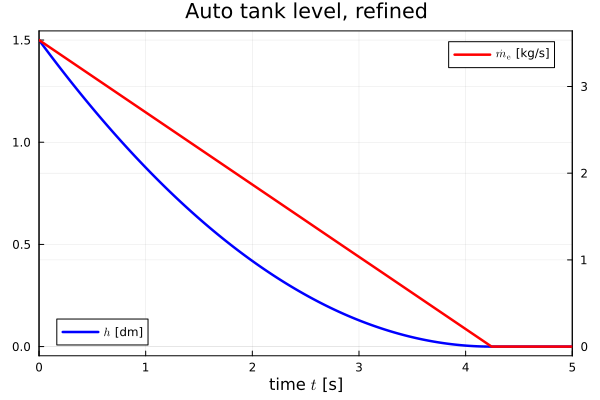

In [43]:
plot(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label = L"$h$ [dm]", legend=:bottomleft)
plot!(title="Auto tank level, refined", xlabel=L"time $t$ [s]")
plot!(twinx(),sol,idxs = [ṁ_e], lc=LC1,lw=LW1,xlabel="",label = L"$\dot{m}_\mathrm{e}$ [kg/s]")
plot!(framestyle =:box, grid=true)

Here, we have created a plot with twin ordinate axes ("y-axes"). Labels are located close to the axis that is relevant for the particular variable, i.e., the left hand side ordinate axis (range: 0-1.5) is valid for the level $h$, while the right hand side ordinate axis (range: 0-3) is valid for the effluent $\dot{m}_\mathrm{e}$.

## 2. Constant area tank with influent
When the model has an influent, it will not become empty, so there is little chance that the level $h$ becomes negative by numerical error. Because of this, we can now use the simple expression for effluent.

We will use two input functions: one with constant value of 2, `ṁ_const(t)`, and one which starts at value 2 and then jumps down to value 1.5 at time = 1, `ṁ_step(t)`. The actual influent function is denoted `ṁ(t)`, and we set `ṁ(t)` equal to either of `ṁ_const(t)` and `ṁ_step(t)`.

In [44]:
ṁ_const(t) = 2
ṁ_step(t) = t < 1 ? 2 : 1.5    # meaning: if t < 1, then 2, else 1.5
;

### 2.1. Constant influent
We create a function `ṁ(t)`which equals `ṁ_const(t)`:

In [45]:
ṁ(t) = ṁ_const(t);

Because function `ṁ(t)` is unknown to `ModelingToolkit.jl`, it must be *registered* (standard built-in Julia functions such as `sin`, etc., are registered by default) before we can use it:

In [46]:
@register_symbolic ṁ(t)

We now create the model with influent `ṁ_i` which we will set equal to function `ṁ`:

In [47]:
@variables ṁ_i(t)

eqs_3 = [Dt(m) ~ ṁ_i-ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς),
        ṁ_i ~ ṁ(t)]

@named tank = ODESystem(eqs_3)

Model tank with 5 equations
States (5):
  m(t)
  ṁ_e(t)
  ṁ_i(t)
  V(t)
⋮
Parameters (4):
  ρ
  A
  h_ς
  K

In [48]:
tank_simp = structural_simplify(tank)

x0 = [m => 1.5*ρ*A] # Initial state
tspan = (0,15)   # Time span
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters: a vector of 
                                            # assignments of type 
                                            # symbol => value

prob = ODEProblem(tank_simp, x0, tspan, par)

sol = solve(prob);

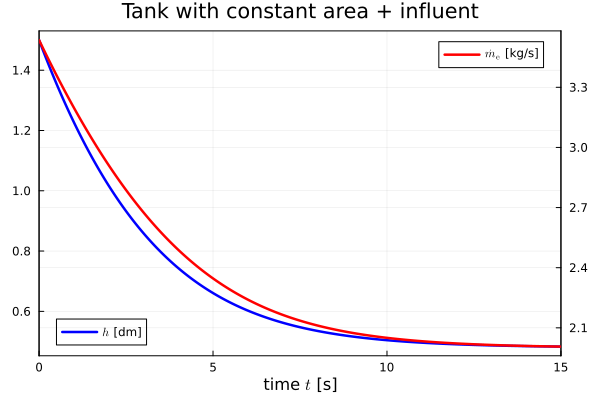

In [49]:
plot(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label = L"$h$ [dm]", legend=:bottomleft)
plot!(title="Tank with constant area + influent", xlabel=L"time $t$ [s]")
plot!(twinx(),sol,idxs = [ṁ_e], lc=LC1,lw=LW1,xlabel="",label = L"$\dot{m}_\mathrm{e}$ [kg/s]")
plot!(framestyle =:box, grid=true)

### 2.2. Time varying influent
Next, we consider a time-varying influent starting at `ṁ_i = 2`, and changing to `ṁ_i = 1.5` at `t = 1`. For this case, we will *start the simulation in steady state*. 

First we create a plot with $m$ from the previous simulation with constant input.

In [50]:
fg_const_input = plot(sol, idxs = [h], xlabel="",lc=LC1,lw=LW1,label = L"$h$ [dm]")
# We want to use fg_const_input in two different plots, so we make a copy
fg_const_input_copy = plot(sol, idxs = [h], xlabel="",lc=LC1,lw=LW1,label = L"$h$ [dm]")
;

Next, we want to simulate the model with input `ṁ_i ~ 2` until it reaches steady state in order to find the steady state value of `m`; we assume steady state has been reached at `t = 100`.

In [51]:
x0 = [m => 1.5*ρ*A] # Initial state
tspan = (0,100)   # Time span
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)

sol = solve(prob)
m_ss = sol[end][1];  # Because sol[end] is a vector, we need to append [1] 
                     # to pick out the scalar value

2.4002252840247174

Next, we *change* function `ṁ(t)` to give a step change:

In [52]:
ṁ(t) = ṁ_step(t);

Then we create a numeric model with initial state `m_ss`:

In [53]:
x0 = [m => m_ss] # Initial state
tspan = (0,15)   # Time span
par = [ρ => 1, A => 5, K => 5, h_ς => 3]    # Parameters

prob = ODEProblem(tank_simp, x0, tspan, par)
                            
sol = solve(prob);

We can now append the new plots to the previous plot (via modifying plot function `plot!()`) with a constant input:

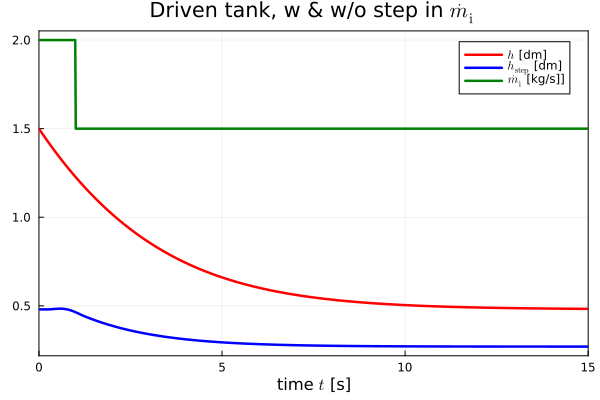

In [54]:
plot!(fg_const_input,sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,label = L"$h_\mathrm{step}$ [dm]")
plot!(sol, idxs = [ṁ_i], xlabel="",lc=LC3,lw=LW1,label = L"$\dot{m}_\mathrm{i}$ [kg/s]]")
plot!(title=L"Driven tank, w & w/o step in $\dot{m}_\mathrm{i}$", xlabel=L"time $t$ [s]")
plot!(framestyle =:box, grid=true)

In [55]:
if SAVEFIG
    figname = "drivenTankSim"
    savefig(figpath*figname*figtype)
end
;

Note that there is a slight "overshoot" in the solution of $h_\mathrm{step}$ in the figure above. This is not realistic, and we could have improved on the result by specifying a better solver than the default one, and/or have specified absolute and relative tolerances for the solver. 

### 2.3. Handling inputs in a smarter way
The implementation workflow we have used so far works well. *HOWEVER*, when we later will want to consider linearization of models, there is a better way to do it.

Note that when we formulate a *symbolic model* (prior to structural simplification), there is no problem with this model being incomplete, i.e., with having more variables (unknowns) than equations. In order to do linearization (later), the model that we linearize *must* have fewer equations than unknowns -- in fact, we can not (in general) have equations for the inputs.

When we do `structural_simplify`, however, the model that we structural simplification of *must* be balances = have the same number of equations and unknowns.

This means that, in general, we must have one version of the model that we can do linearization of, and a model extended with input specifications that we do structural simplification of. This is somewhat unfortunate, so we need to do the modeling in a way that minimizes this problem. [NOTE: there is a way around this by introducing so-called `analysis points`, but that requires more knowledge of ModelingToolkit than discussed here.]

So let us define one model without specifying the inputs, and one model where we specify the inputs. Then we *extend* the model without inputs, with the input specifications.

In [56]:
@parameters ρ=1 A=5 K=5 h_ς=3
@variables t m(t)=1.5*ρ*A ṁ_i(t) ṁ_e(t) V(t) h(t)
Dt = Differential(t)

eqs_b = [Dt(m) ~ ṁ_i-ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank_b = ODESystem(eqs_b)    # Basic tank model, i.e., without inputs

Model tank_b with 4 equations
States (5):
  m(t) [defaults to 1.5A*ρ]
  ṁ_e(t)
  ṁ_i(t)
  V(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]

Observe that model `tank_b` has 5 unknowns and 4 equations, i.e., it is not balanced.

In [57]:
eqs_i = [ṁ_i ~ ṁ(t)]
@named tank_i = ODESystem(eqs_i)    # Model of inputs to the tank

Model tank_i with 1 equations
States (1):
  ṁ_i(t)
Parameters (0):

In [58]:
tank = extend(tank_i, tank_b)

Model tank_i with 5 equations
States (5):
  m(t) [defaults to 1.5A*ρ]
  ṁ_e(t)
  ṁ_i(t)
  V(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]

Now, the model is *balanced*, i.e., the number of equations equals the number of unknown variables.

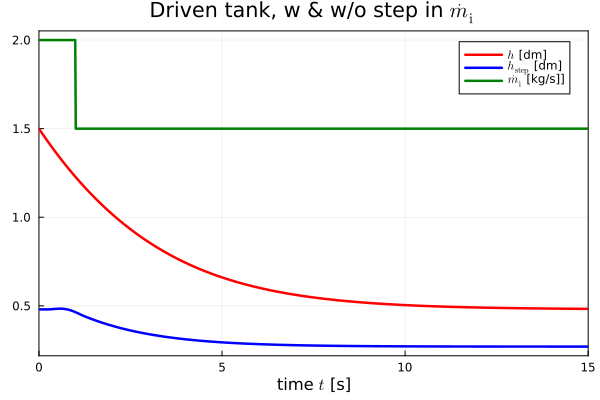

In [59]:
tank_simp = structural_simplify(tank)
prob = ODEProblem(tank_simp, [m=>m_ss], tspan)
sol = solve(prob)

plot(fg_const_input_copy)
plot!(sol, idxs = [h], xlabel="",lc=LC2,lw=LW1,
        label = L"$h_\mathrm{step}$ [dm]")
plot!(sol, idxs = [ṁ_i], xlabel="",lc=LC3,lw=LW1,
        label = L"$\dot{m}_\mathrm{i}$ [kg/s]]")
plot!(title=L"Driven tank, w & w/o step in $\dot{m}_\mathrm{i}$", 
        xlabel=L"time $t$ [s]")
plot!(framestyle =:box, grid=true)


## 3. Fine-tuning model implementation
### 3.1. Structure of variables and parameters
It is of interest to understand the structure of what is produced when creating parameters and variables. As we will see, it is also possible to add arguments to the `ODESystem` constructor.

First, the structure of definitions of `@variables` and `@parameters`.

In [60]:
@parameters ρ A K

3-element Vector{Num}:
 ρ
 A
 K

In [61]:
@parameters h_ς

1-element Vector{Num}:
 h_ς

As we see, the result is a *vector*. Sometimes, we want to have a vector of *all* parameters, and be able to *refer* to the parameter vector by name. We can do this as follows:

In [62]:
pars1 = @parameters ρ A K

3-element Vector{Num}:
 ρ
 A
 K

In [63]:
pars2 = @parameters h_ς

1-element Vector{Num}:
 h_ς

In [64]:
pars = [pars1; pars2]

4-element Vector{Num}:
   ρ
   A
   K
 h_ς

However, this is somewhat cumbersome. Instead, we can do as follows:

In [65]:
pars = @parameters ρ A K h_ς

4-element Vector{Num}:
   ρ
   A
   K
 h_ς

...or as:

In [66]:
pars = @parameters (ρ, A, K, h_ς)

4-element Vector{Num}:
   ρ
   A
   K
 h_ς

The latter construct is advantageous, because it (i) allows us to specify default values and the consctruct still works, and (ii) we can spread the definition of parameters over several lines:

In [67]:
pars = @parameters(ρ=1, A=5, K=5,
                   h_ς=3)

4-element Vector{Num}:
   ρ
   A
   K
 h_ς

Finally, it is adviceable to make a separation between the *independent variable* (normallly time $t$ in this course), and the dependent variables. Thus, the following structure would be adviceable.

In [68]:
# Independent variables
@variables t 
# Differential operator
Dt = Differential(t)
# Parameters
pars = @parameters (ρ=1, A=5, K=5, h_ς=3)
# Dependent variables 
vars = @variables (m(t)=1.5*ρ*A, ṁ_e(t), V(t), h(t))
;

### 3.2. Fields of object created by constructor `ODESystem`
Constructor `ODESystem` creates a data structure/object with certain fields. From the documentation of `ODESystem`, some of the most basic fields are:

`name`: Name: the name of the system.

`eqs`: The ODEs defining the system.

`iv`: Independent variable.

`ps`: Parameter variables. Must not contain the independent variable.

`states`: Dependent ("state") variables. Must not contain the independent variable.

`observed`: Observed states.

`defaults`: defaults: The default values to use when initial conditions and/or parameters are not supplied in ODEProblem.

`metadata`: metadata for the system (e.g., units), to be used by downstream packages.

Let us check out some of these fields.

In [69]:
eqs = [Dt(m) ~ -ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ max(K*sign(h)*sqrt(abs(h/h_ς)),0)]

@named tank = ODESystem(eqs)

tank_simp = structural_simplify(tank)

Model tank with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  h_ς [defaults to 3]
  K [defaults to 5]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [70]:
tank.name, tank_simp.name

(:tank, :tank)

In [71]:
tank_simp.eqs

Equation[Differential(t)(m(t)) ~ -ṁ_e(t)][1:1]

In [72]:
tank_simp.iv

t

In [73]:
tank_simp.ps

SymbolicUtils.BasicSymbolic{Real}[ρ, A, h_ς, K][1:4]

In [74]:
tank_simp.states

Any[m(t)][1:1]

In [75]:
tank_simp.observed

Equation[V(t) ~ m(t) / ρ, h(t) ~ V(t) / A, ṁ_e(t) ~ max(K*sign(h(t))*sqrt(abs(h(t) / h_ς)), 0)][1:3]

In [76]:
tank_simp.defaults

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 5
  ρ    => 1

In [77]:
tank_simp.metadata

We have previously seen functions such as `equations`, `states`, `observed`, etc. These are simply functions that read the field values (as above), and present them in a nicer way.

In addition to the functions `equations`, `states`, and `observed`, there is a function `defaults` - but this one is not *exported* by default, and needs to be called as `ModelingToolkit.defaults()`.

In [78]:
ModelingToolkit.defaults(tank_simp)

Dict{Any, Any} with 5 entries:
  h_ς  => 3
  K    => 5
  m(t) => 1.5A*ρ
  A    => 5
  ρ    => 1

Because we have not defined *meta data*, the field `metadata` is empty.

### 3.3. Call signature of `ODESystem` constructor
We have seen that we can construct an `ODESystem` by `ODESystem(eqs)`. It is, however, possible to use other call signatures, e.g., `ODESystem(eqs, independent_variable, variables, parameters)`. When we use the simplified version `ODESystem(eqs)` these additional variables are extracted from the equations.

However, at times, the constructor may get confused by our model/equations when we use a single input argument. Providing additional arguments will help the constructor to create a correct model.

To illustrate this, assume the following "academic" example:

In [79]:
@variables t 
Dt = Differential(t)
pars = @parameters (a=10, b=a/10, c=a/20)
vars = @variables (x(t) = 1, z(t))

eqs = [ Dt(x) ~ -b*(x-z),
    0 ~ z + c*x]

2-element Vector{Equation}:
 Differential(t)(x(t)) ~ -b*(x(t) - z(t))
 0 ~ c*x(t) + z(t)

In [80]:
@named sys = ODESystem(eqs)
sys_simp = structural_simplify(sys)

Model sys with 1 equations
States (1):
  x(t) [defaults to 1]
Parameters (2):
  b [defaults to (1//10)*a]
  c [defaults to (1//20)*a]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [81]:
states(sys_simp)

1-element Vector{Any}:
 x(t)

In [82]:
observed(sys_simp)

1-element Vector{Equation}:
 z(t) ~ -c*x(t)

In [83]:
ModelingToolkit.defaults(sys_simp)

Dict{Any, Any} with 3 entries:
  x(t) => 1
  b    => (1//10)*a
  c    => (1//20)*a

**Observe** that parameter `a` which has a default value, does not show up *explicitly* in the equations, and that `b` and `c` are defined *via* `a`. This has a consequence when we create a numeric version of the model...

In [84]:
tspan = (0,3)

prob = ODEProblem(sys_simp, [], tspan)

MethodError: MethodError: no method matching AbstractFloat(::Type{SymbolicUtils.BasicSymbolic{Real}})

Closest candidates are:
  (::Type{T})(!Matched::SymbolicUtils.Symbolic) where T<:Union{AbstractFloat, Integer, Complex{<:AbstractFloat}, Complex{<:Integer}}
   @ Symbolics C:\Users\Bernt_Lie\.julia\packages\Symbolics\BQlmn\src\Symbolics.jl:141
  (::Type{T})(!Matched::AbstractChar) where T<:Union{AbstractChar, Number}
   @ Base char.jl:50
  (::Type{T})(!Matched::Base.TwicePrecision) where T<:Number
   @ Base twiceprecision.jl:266
  ...


What happens if we instead use the `ODESystem` constructor with 4 inputs?

In [85]:
@named sys1 = ODESystem(eqs, t, vars, pars)

Model sys1 with 2 equations
States (2):
  x(t) [defaults to 1]
  z(t)
Parameters (3):
  a [defaults to 10]
  b [defaults to (1//10)*a]
  c [defaults to (1//20)*a]

In [86]:
sys1_simp = structural_simplify(sys1)

Model sys1 with 1 equations
States (1):
  x(t) [defaults to 1]
Parameters (3):
  a [defaults to 10]
  b [defaults to (1//10)*a]
  c [defaults to (1//20)*a]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [87]:
ModelingToolkit.defaults(sys1_simp)

Dict{Any, Any} with 4 entries:
  a    => 10
  x(t) => 1
  b    => (1//10)*a
  c    => (1//20)*a

We see that this time, the symbolic function is aware of all parameters (including `a`), and has given values to them. The reason is that this time, we have *explicitly* provided the vector of parameters to the constructor, while if we only provide the *equations*, the constructor parses the equations to find parameters... and parameter `a` is missing from the equations.

Let us try to solve the model based on the 4-input constructor:

In [88]:
prob = ODEProblem(sys1_simp, [], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 3)
u0: 1-element Vector{Float64}:
 1.0

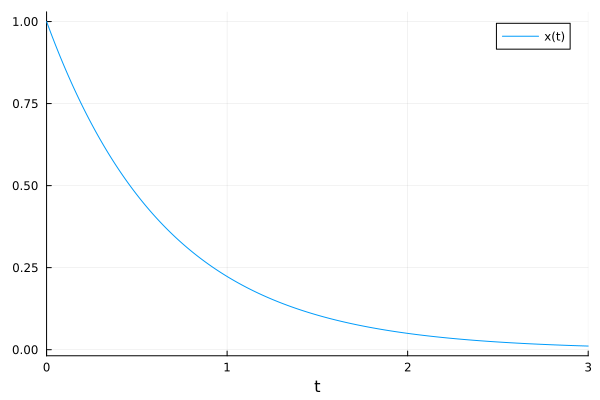

In [89]:
sol = solve(prob)

plot(sol)

## 4. Best practice for ModelingToolkit
Based on the previous discussion, we can summarize some best practice for model description in ModelingToolkit.

### 4.1. Specifying variables and parameters

1. Start by defining the *independent variable*, normally `t` for dynamic systems
2. Next, define a short for the differential operator. `Dt` is preferred to also indicate the independet variable.
3. Next, specify a named parameter object as a tuple *with default values* -- using a tuple makes it simple to split the parameter list over many lines.
4. Next, specify a named variable object as a tuple, use as many default variables as useful.

Example for the tank model:

In [90]:
# Independent variables
@variables t 
# Differential operator
Dt = Differential(t)
# Parameters
pars = @parameters (ρ=1, A=5, K=5, h_ς=3)
# Dependent variables 
vars = @variables (m(t)=1.5*ρ*A, ṁ_i(t), ṁ_e(t), V(t), h(t))
;

### 4.2. Specifying *basic* model

Next, 
* Create the *basic* model using constructur `ODESystem` without defining inputs.
* Use the additional arguments of independent variables, variables, and parameters for constructor `ODESystem` to make sure that no parameters, etc. are "forgotten".

The resulting equations/model will be *unbalanced*, here:

In [91]:
eqs_b = [Dt(m) ~ ṁ_i-ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank_b = ODESystem(eqs_b, t, vars, pars)    # Basic tank model, i.e., without inputs

Model tank_b with 4 equations
States (5):
  m(t) [defaults to 1.5A*ρ]
  ṁ_i(t)
  ṁ_e(t)
  V(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  K [defaults to 5]
  h_ς [defaults to 3]

Observe that in `eqs_b` (equations) and `tank_b` (model), we have *5 unknowns* [$m$, $\dot{m}_\mathrm{e}$, $\dot{m}_\mathrm{i}$, $V$, $h$], and only *4 equations* -- hence the model is unbalanced.

### 4.3. Specifying input model
Next, create a model for specifying the *inputs*. Before we can do that, we need to register the symbolic input function.

In [92]:
@register_symbolic ṁ(t)

With `ṁ(t)` defined symbolically, we are now ready to use this in the input model.

In [93]:
eqs_i = [ṁ_i ~ ṁ(t)]
@named tank_i = ODESystem(eqs_i)    # Model of inputs to the tank

Model tank_i with 1 equations
States (1):
  ṁ_i(t)
Parameters (0):

Notice: so far, we have not defined a *concrete* form of the input function $\dot{m}(t)$.

The purpose of splitting the model into the *basic* model and the *input* model is that we can then later do symbolic linearization of the *basic* model; in the linearization procedure, we need to have more unknowns (= inputs) than equations.

### 4.4. Creating balanced model followed by index reduction

To be able to reduce the model to DAE of index 1, we *must* have a balanced model. This is done by *extending* the basic model with the input model:

In [94]:
tank = extend(tank_i, tank_b)

Model tank_i with 5 equations
States (5):
  m(t) [defaults to 1.5A*ρ]
  ṁ_i(t)
  ṁ_e(t)
  V(t)
⋮
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  K [defaults to 5]
  h_ς [defaults to 3]

Now, we are ready to reduce the model to a DAE of index 1:

In [95]:
tank_simp = structural_simplify(tank)

Model tank_i with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  K [defaults to 5]
  h_ς [defaults to 3]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [96]:
full_equations(tank_simp)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ ṁ(t) - K*sqrt(m(t) / (A*h_ς*ρ))

In [97]:
observed(tank_simp)

4-element Vector{Equation}:
 V(t) ~ m(t) / ρ
 ṁ_i(t) ~ ṁ(t)
 h(t) ~ V(t) / A
 ṁ_e(t) ~ K*sqrt(h(t) / h_ς)

### 4.5. Specifying initial state, time span, input function
Before converting the symbolic model to a numeric model, we need to make sure that we have given initial values to the "state". The "state" is found to be:

In [98]:
states(tank_simp)

1-element Vector{Any}:
 m(t)

This means that we need to provide an initial value to (in this case) $m$. Here, we have already done so.

Before we can convert the symbolic model to a numeric model/problem, we need to:
1. Define a time span/tuple of initial time and final time,
2. Give a concrete function form to the symbolic input function (here: $\dot{m}$)

In [99]:
tspan = (0,10)

ṁ(t) = 2 + 0.1*sin(2pi*t/4)
;

### 4.6. Converting symbolic model to numeric problem
We can now convert the model to a numeric problem:

In [100]:
prob = ODEProblem(tank_simp, [], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 10)
u0: 1-element Vector{Float64}:
 7.5

### 4.7. Choosing solver, and finding solution
Finally, we can solve the problem. To choose an appropriate solver, we need to re-check the equations: if any of the equations are *algebraic*, we need to use a solver with *mass matrix*. If all equations are differential equations, we can use a standard ODE solver:

In [101]:
equations(tank_simp)

1-element Vector{Equation}:
 Differential(t)(m(t)) ~ ṁ_i(t) - ṁ_e(t)

Here, we only have differential equations. Therefore we use a solver without mass matrix -- here, we use solver `Tsit5()`.

In [102]:
sol = solve(prob, Tsit5())
;

### 4.8. Inspecting results
Finally, we are interested in inspecting the solution:

In [103]:
sol(0.1)

1-element Vector{Float64}:
 7.349025806493715

In [104]:
sol(0.1,idxs=h)

1.4698051612987428

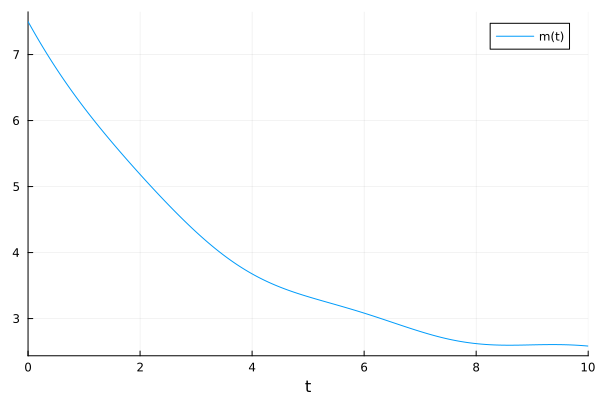

In [105]:
plot(sol)

## 5. Resusable model
We have so far only scratched the surface of ModelingToolkit. For modeling languages such as ModelingToolkit, the possibility to create a model constructor for simple model re-use, is important.
### 5.1. Previous model formulation
From "Best practice for ModelingToolkit":

In [106]:
# Independent variables
@variables t 
# Differential operator
Dt = Differential(t)
# Parameters
pars = @parameters (ρ=1, A=5, K=5, h_ς=3)
# Dependent variables 
vars = @variables (m(t)=1.5*ρ*A, ṁ_i(t), ṁ_e(t), V(t), h(t))
;

In [107]:
eqs_b = [Dt(m) ~ ṁ_i-ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

@named tank_b = ODESystem(eqs_b, t, vars, pars)

eqs_i = [ṁ_i ~ ṁ(t)]
@named tank_i = ODESystem(eqs_i)

tank = extend(tank_i, tank_b)
tank_simp = structural_simplify(tank)

Model tank_i with 1 equations
States (1):
  m(t) [defaults to 1.5A*ρ]
Parameters (4):
  ρ [defaults to 1]
  A [defaults to 5]
  K [defaults to 5]
  h_ς [defaults to 3]
Incidence matrix:1×2 SparseArrays.SparseMatrixCSC{Num, Int64} with 2 stored entries:
 ×  ×

In [108]:
tspan = (0,5)

prob1 = ODEProblem(tank_simp, [], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 5)
u0: 1-element Vector{Float64}:
 7.5

### 5.2. Model constructor
Instead of creating the model as above, we can create a *constructor* for a model which can be reused. This involves packaging the model into a function, and a model can then be instantiated by calling this constructor. Observe that when we want to be able to *re-use* the model, we should not specify the input $\dot{m}_\mathrm{i}$ -- the value of the input may be specified outside of the model constructor.

In [109]:
# Generic tank model
function tank_model(; name)
    # Independent variables
    @variables t 
    # Differential operator
    Dt = Differential(t)
    # Parameters
    pars = @parameters (ρ=1, A=5, K=5, h_ς=3)
    # Dependent variables 
    vars = @variables (m(t)=1.5*ρ*A, ṁ_i(t), ṁ_e(t), V(t), h(t))
    #
    eqs = [Dt(m) ~ ṁ_i-ṁ_e,
        m ~ ρ*V,
        V ~ A*h,
        ṁ_e ~ K*sqrt(h/h_ς)]

    ODESystem(eqs, t, vars, pars; name)
    #
end
;

### 5.3. Instantiation of tank models

In [110]:
@named tanka = tank_model()
@named tankb = tank_model()
;

### 5.4. Connecting tanks and creating system

In [111]:
connections = [tanka.ṁ_i ~ ṁ(t),
                tanka.ṁ_e ~ tankb.ṁ_i]

tanksys = compose(ODESystem(connections; name=:sys), tanka, tankb)

tanksys_simp = structural_simplify(tanksys)

Model sys with 2 equations
States (2):
  tanka₊m(t) [defaults to 1.5tanka₊A*tanka₊ρ]
  tankb₊m(t) [defaults to 1.5tankb₊A*tankb₊ρ]
Parameters (8):
  tanka₊ρ [defaults to 1]
  tanka₊A [defaults to 5]
  tanka₊K [defaults to 5]
  tanka₊h_ς [defaults to 3]
⋮
Incidence matrix:2×4 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ⋅  ×  ⋅
 ×  ×  ⋅  ×

### 5.5. Creating Numeric problem and Solution

In [112]:
tspan = (0,30)
prob = ODEProblem(tanksys_simp, [], tspan)

ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 30)
u0: 2-element Vector{Float64}:
 7.5
 7.5

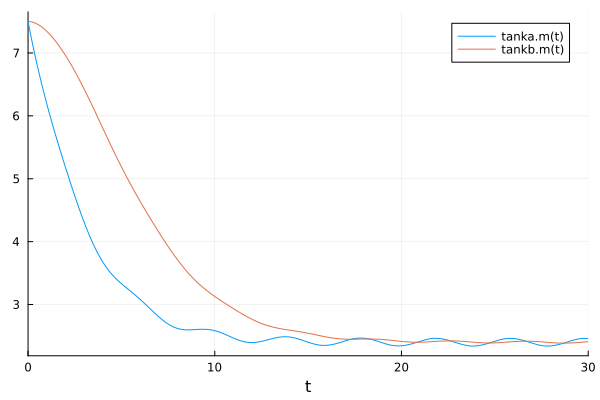

In [113]:
sol = solve(prob)

plot(sol)

## 6. Index 1 DAE: Incompressible Liquid Pipe Flow
The following model illustrates a case where ModelingToolkit simplifies the model to an index 1 DAE, with resulting required use of mass matrix solver.

### 6.1. Model of pipe
We consider a pipe of length $L$ with cross sectional area $A_\mathrm{p}$, with incompressible liquid density $\rho$ and hence constant mass $m$,
$$
m = \rho A_\mathrm{p} L
$$
Because of incompressibility, the balance equation for momentum $\mathfrak{m}$ reduces to Newton's law with force $F$,
$$
\frac{\mathrm{d}\mathfrak{m}}{\mathrm{d} t} = F
$$
where momentum is
$$
\mathfrak{m} = mv
$$
and $v$ is linear velocity. Linear velocity is related to volumetric flow rate $\dot{V}$ as
$$
\dot{V} = A_\mathrm{p}v
$$
Mass flow rate $\dot{m}$ is related to volumetric flow rate as 
$$
\dot{m}_\mathrm{p} = \rho \dot{V}
$$
and is also given by the effluent pressure drop through a valve,
$$
\dot{m}_\mathrm{p} = K_\mathrm{e} u \sqrt{\frac{\Delta p_\mathrm{e}}{p^\varsigma}}
$$
where $u$ is the valve control signal (opening) and $\Delta p_\mathrm{e}$ is the pressure drop over the outlet valve. Here
$$
\Delta p_\mathrm{e} = p_\mathrm{e} - p_\mathrm{a}
$$
where $p_\mathrm{e}$ is the pressure in front of the valve, and atmospheric pressure $p_\mathrm{a}$ is the pressure at the exit from the valve.

Force $F$ is given as
$$
F = F_\mathrm{g} - F_\mathrm{f} + F_\mathrm{p}
$$
where gravity force $F_\mathrm{g} = m g H/L$ is constant with $H$ the elevation drop from pipe inlet to effluent valve, friction force $F_\mathrm{f}$ is
$$
F_\mathrm{f} = k\cdot v\cdot|v|.
$$
Pressure force $F_\mathrm{p}$ is
$$
F_\mathrm{p} = A_\mathrm{p}(p-p_\mathrm{e})
$$
with $p$ the pipe inlet pressure from a reservoir. The inlet from the reservoir is at position $h$ below the reservoir level, thus $p$ is given as 
$$
p = p_\mathrm{a} + \rho g h.
$$

In summary, we have:
* 11 parameters $\rho$, $L$, $A_\mathrm{p}$, $m$, $K_\mathrm{e}$, $p_\mathrm{a}$, $p^\varsigma$, $g$, $H$, $F_\mathrm{g}$, $k$
* 12 unknowns $v$, $\mathfrak{m}$, $F$, $\dot{V}$, $\dot{m}_\mathrm{p}$, $u$, $\Delta p_\mathrm{e}$, $p_\mathrm{e}$, $F_\mathrm{f}$, $F_\mathrm{p}$, $p$, $h$ 
* 10 equations

To complete the model, we need to specify the two inputs valve signal $u$ and reservoir level $h$.

### 6.2. Variables, parameters, and differentiaton operator

In [114]:
# Independent variables
@variables t 
# Differential operator
Dt = Differential(t)
# Parameters
pars = @parameters (ρ=1e3, L=200, A_p=1.5, m=ρ*A_p*L, K_e=2e3, p_a=1.01e5, p_ς=p_a, 
            g=9.81, H=100, F_g=m*g*H/L, k=4e4)
# Dependent variables 
vars = @variables (v(t)=2, 𝔪(t)=m*v, F(t), V̇(t)=v*A_p, ṁ_p(t)=ρ*V̇, u(t)=0.5, 
            Δp_e(t)=p_ς*(ṁ_p/K_e/u)^2, p_e(t), F_f(t), F_p(t), p(t), h(t))
;

### 6.3. Basic model

In [115]:
eqs_b = [Dt(𝔪) ~ F,
        𝔪 ~ m*v,
        V̇ ~ A_p*v,
        ṁ_p ~ ρ*V̇,
        ṁ_p ~ K_e*u*sqrt(Δp_e/p_ς),
        Δp_e ~ p_e - p_a,
        F ~ F_g - F_f + F_p,
        F_f ~ k*v*abs(v),
        F_p ~ (p-p_e)*A_p,
        p ~ p_a + ρ*g*h]

@named pipe_b = ODESystem(eqs_b, t, vars, pars)

Model pipe_b with 10 equations
States (12):
  v(t) [defaults to 2]
  𝔪(t) [defaults to m*v(t)]
  F(t)
  V̇(t) [defaults to A_p*v(t)]
⋮
Parameters (11):
  ρ [defaults to 1000.0]
  L [defaults to 200]
  A_p [defaults to 1.5]
  m [defaults to A_p*L*ρ]
⋮

### 6.4. Registering inputs + input model

In [116]:
@register_symbolic u_u(t)
@register_symbolic h_u(t)
#
eqs_i = [u ~ u_u(t),
            h ~ h_u(t)]
@named pipe_i = ODESystem(eqs_i)

Model pipe_i with 2 equations
States (2):
  u(t) [defaults to 0.5]
  h(t)
Parameters (0):

### 6.5. Composed model with simplification and states

In [117]:
pipe = extend(pipe_i, pipe_b)

pipe_simp = structural_simplify(pipe)

Model pipe_i with 2 equations
States (2):
  𝔪(t) [defaults to m*v(t)]
  Δp_e(t) [defaults to p_ς*((ṁ_p(t) / (K_e*u(t)))^2)]
Parameters (11):
  ρ [defaults to 1000.0]
  L [defaults to 200]
  A_p [defaults to 1.5]
  m [defaults to A_p*L*ρ]
⋮
Incidence matrix:2×3 SparseArrays.SparseMatrixCSC{Num, Int64} with 5 stored entries:
 ×  ×  ×
 ×  ⋅  ×

In [118]:
states(pipe_simp)

2-element Vector{Any}:
 𝔪(t)
 Δp_e(t)

From the `pipe_simp` structure, which contains one differential equation and one algebraic equation, we observe that we must use an ODE solver with support for mass matrix. A good solver is, e.g., `QNDF()`.

Next, from the list of "states", we observe that we need to provide initial values for $\mathfrak{m}$ and $\Delta p_\mathrm{e}$. We have already provided this in the specification of the `vars` object.

### 6.6. Defining concrete inputs + time span + generating numeric problem

Before we can create the numeric problem, we need to define concrete functions to `u_u` and `h_u`.

In [119]:
h_u_const(t) = 5
u_u_const(t) = 0.5
u_u_step(t) = t<4 ? 0.5 : 0.4

h_u(t) = h_u_const(t)
u_u(t) = u_u_step(t)

tspan = (0,8)
;

In [120]:
prob = ODEProblem(pipe_simp, [], tspan)

# This problem appears to be tricky numerically, so not all algorithms will work. Also, because the structgurally
# simplified model contains an algebraic equation, it is necessary to find a solver that supports mass matrix



ODEProblem with uType Vector{Float64} and tType Int64. In-place: true
timespan: (0, 8)
u0: 2-element Vector{Float64}:
 600000.0
 908999.9999999999

### 6.7. Solving model, and presenting results
Observe that we use solver `QNDF()`, which has mass matrix support and is of good quality.

In [121]:
sol = solve(prob,QNDF());

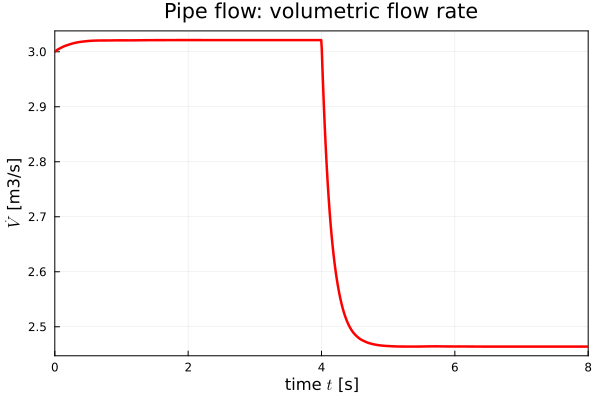

In [122]:
plot(sol,idxs=V̇, lw=LW1, lc=LC1, label="")
plot!(title="Pipe flow: volumetric flow rate",
    xlabel=L"time $t$ [s]", ylabel=L"$\dot{V}$ [m3/s]")
plot!(framestyle =:box, grid=true, legend=:topright)

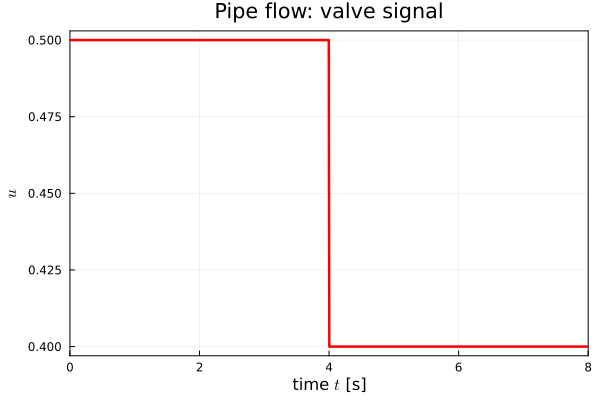

In [123]:
plot(sol,idxs=u, lw=LW1, lc=LC1, label="")
plot!(title="Pipe flow: valve signal",
    xlabel=L"time $t$ [s]", ylabel=L"u")
plot!(framestyle =:box, grid=true, legend=:topright)

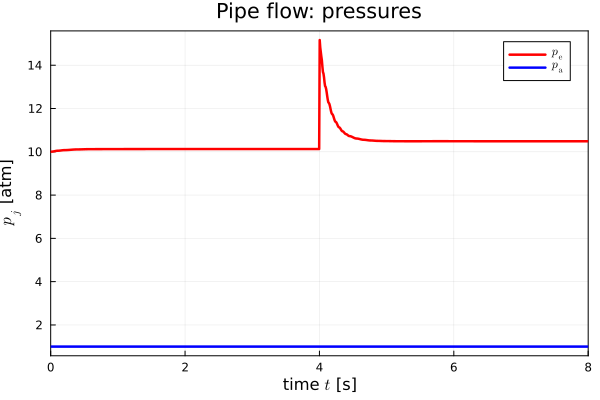

In [124]:
plot(sol,idxs=p_e/1.01e5, lw=LW1, lc=LC1, label=L"p_\mathrm{e}")
hline!([sol(0,idxs=p_a)/1.01e5],lw=LW1,lc=LC2,label=L"p_\mathrm{a}")
plot!(title="Pipe flow: pressures",
    xlabel=L"time $t$ [s]", ylabel=L"$p_j$ [atm]")
plot!(framestyle =:box, grid=true, legend=:topright)

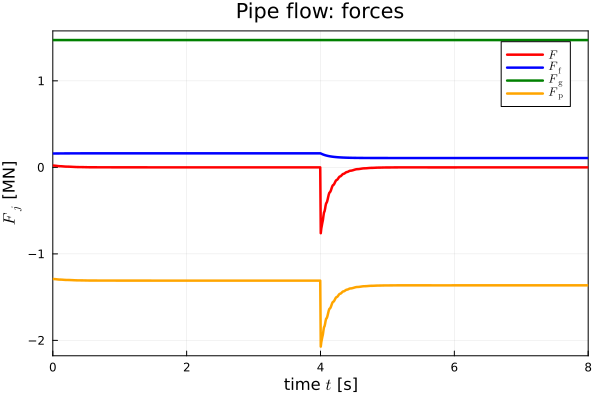

In [125]:
plot(sol,idxs=[F/1e6, F_f/1e6], lw=LW1, lc=[LC1 LC2], label=[L"F" L"F_\mathrm{f}"])
hline!([sol(0,idxs=F_g)/1e6],lw=LW1,lc=LC3,label=L"F_\mathrm{g}")
plot!(sol, idxs = F_p/1e6, lw=LW1, lc=LC4, label=L"F_\mathrm{p}")
plot!(title="Pipe flow: forces",
    xlabel=L"time $t$ [s]", ylabel=L"$F_j$ [MN]")
plot!(framestyle =:box, grid=true, legend=:topright)

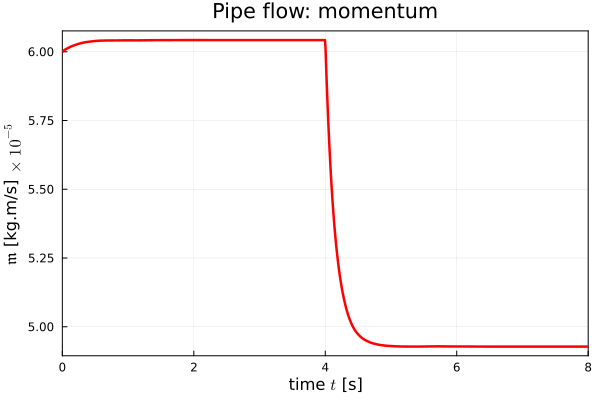

In [126]:
plot(sol,idxs=𝔪/1e5, lw=LW1, lc=LC1, label="")
plot!(title="Pipe flow: momentum",
    xlabel=L"time $t$ [s]", ylabel=L"$\mathfrak{m}$ [kg.m/s]$\ \times 10^{-5}$")
plot!(framestyle =:box, grid=true, legend=:topright)